<https://github.com/PolymathicAI/xVal>


In [1]:
from flax import nnx
import flax

flax.__version__

'0.10.2'

In [2]:
import ast
import re
from datetime import datetime as dt
import os

import icecream
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import pandas as pd
import optax
from flax.struct import dataclass
from icecream import ic
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange
from transformers import BertTokenizerFast, FlaxBertModel

import hephaestus as hp

icecream.install()
ic_disable = False  # Global variable to disable ic
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)
pd.options.mode.copy_on_write = True

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = FlaxBertModel.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

# Get the embeddings matrix
embeddings = model.params["embeddings"]["word_embeddings"]["embedding"]

# Now you can access specific embeddings like this:
# For example, to get embeddings for tokens 23, 293, and 993:
selected_embeddings = jnp.take(embeddings, jnp.array([23, 293, 993]), axis=0)

# If you want to get embeddings for specific words:
words = ["hello", "world", "example"]
tokens = tokenizer.convert_tokens_to_ids(words)
word_embeddings = jnp.take(embeddings, jnp.array(tokens), axis=0)
word_embeddings.shape

Some weights of FlaxBertModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: {('pooler', 'dense', 'bias'), ('pooler', 'dense', 'kernel')}
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(3, 768)

In [5]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [6]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")


# Combine total mass of all planets into one column `planet<n>_m`
mass_regex = re.compile(r"planet(\d+)_m")
mass_cols = [col for col in df.columns if mass_regex.match(col)]
df["total_mass"] = df[mass_cols].sum(axis=1)
# df = df.reset_index(drop=True)
# Introduce categorical columns for the number of planets choose non null columns with mass
df["n_planets"] = df[mass_cols].notnull().sum(axis=1).astype("object")
df["n_planets"] = df["n_planets"].apply(lambda x: f"{x}_planets")
# Create category acceleration if the sum of plane/d_[x,y, z] is greater than 0
df["acceleration_x"] = df[
    [col for col in df.columns if "planet" in col and "_x" in col]
].sum(axis=1)
# Set acceleration_x to "increasing" if greater than 0 else "decreasing"
df["acceleration_x"] = (
    df["acceleration_x"]
    .apply(lambda x: "increasing" if x > 0 else "decreasing")
    .astype("object")
)
df["acceleration_y"] = df[
    [col for col in df.columns if "planet" in col and "_y" in col]
].sum(axis=1)
df["acceleration_y"] = df["acceleration_y"].apply(
    lambda x: "increasing" if x > 0 else "decreasing"
)


df.describe()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
count,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,5.563957e+06,4.165044e+06,4.165044e+06,5.563957e+06,5.563957e+06,...,2.783627e+06,2.783627e+06,2.783627e+06,2.783627e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,1.392864e+06,5.563957e+06
mean,6.248635e+04,9.748911e+00,-1.339198e-01,7.391138e-02,-1.340140e-01,7.291389e-02,-1.305344e-01,7.065633e-02,2.999306e+00,1.624756e+00,...,6.559150e-02,2.996303e+00,1.623874e+00,9.980576e-01,-1.276881e-01,6.519469e-02,3.002531e+00,1.625815e+00,1.001317e+00,1.049149e+01
std,3.607949e+04,5.993534e+00,1.228071e+00,1.213232e+00,1.227950e+00,1.212650e+00,1.217229e+00,1.203678e+00,1.157182e+00,5.876632e-01,...,1.200148e+00,1.153190e+00,5.270725e-01,5.764675e-01,1.211648e+00,1.199625e+00,1.156856e+00,5.167198e-01,5.779763e-01,3.991780e+00
min,0.000000e+00,0.000000e+00,-3.294763e+00,-2.997514e+00,-3.284004e+00,-2.998546e+00,-3.289790e+00,-2.998050e+00,1.000003e+00,1.000000e+00,...,-2.997621e+00,1.000054e+00,1.000000e+00,9.369537e-05,-3.273603e+00,-2.998913e+00,1.000103e+00,1.000000e+00,6.720938e-05,2.014597e+00
25%,3.124400e+04,4.655172e+00,-1.030131e+00,-9.020907e-01,-1.030516e+00,-9.028009e-01,-1.050662e+00,-9.211662e-01,1.993948e+00,1.000000e+00,...,-9.321272e-01,1.996853e+00,1.191548e+00,4.980967e-01,-1.071974e+00,-9.394428e-01,2.004240e+00,1.215927e+00,5.032645e-01,7.282371e+00
50%,6.249100e+04,9.523810e+00,-1.542335e-01,1.117099e-01,-1.538916e-01,1.099474e-01,-1.525520e-01,1.118031e-01,2.994477e+00,1.543047e+00,...,1.067355e-01,3.001879e+00,1.535683e+00,9.955040e-01,-1.507184e-01,1.055276e-01,3.000454e+00,1.519040e+00,1.003118e+00,1.028205e+01
75%,9.372800e+04,1.440000e+01,8.583344e-01,9.784987e-01,8.581045e-01,9.783998e-01,8.762358e-01,9.912902e-01,4.005747e+00,2.020672e+00,...,9.956064e-01,3.986406e+00,1.969644e+00,1.497746e+00,8.906780e-01,9.991220e-01,4.003332e+00,1.950518e+00,1.503457e+00,1.345633e+01
max,1.249990e+05,2.400000e+01,2.996370e+00,2.999014e+00,2.993319e+00,2.999536e+00,2.990464e+00,2.998478e+00,4.999994e+00,2.999984e+00,...,3.000881e+00,4.999990e+00,2.999909e+00,1.999957e+00,2.985180e+00,2.998936e+00,4.999679e+00,2.999497e+00,1.999999e+00,2.382455e+01


In [ ]:
df.head()

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
0,0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
1,0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
2,0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
3,0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing
4,0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,1.312562,1.944263,...,NaN,NaN,NaN,NaN,NaN,NaN,6.974122,3_planets,increasing,increasing


In [8]:
df_categorical = df.select_dtypes(include=["object"]).astype(str)
unique_values_per_column = df_categorical.apply(
    pd.Series.unique
).values  # .flatten().tolist()
flattened_unique_values = np.concatenate(unique_values_per_column).tolist()
unique_values = list(set(flattened_unique_values))
unique_values

['3_planets',
 '5_planets',
 'increasing',
 'decreasing',
 '4_planets',
 '2_planets']

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [10]:
tokenizer.vocab_size

30522

In [11]:
df.select_dtypes(include="object").groupby(
    df.select_dtypes(include="object").columns.tolist()
).size().reset_index(name="count")

,n_planets,acceleration_x,acceleration_y,count
0,2_planets,decreasing,decreasing,365720
1,2_planets,decreasing,increasing,410992
2,2_planets,increasing,decreasing,272240
3,2_planets,increasing,increasing,349961
4,3_planets,decreasing,decreasing,410092
5,3_planets,decreasing,increasing,404513
6,3_planets,increasing,decreasing,258536
7,3_planets,increasing,increasing,308276
8,4_planets,decreasing,decreasing,413451
9,4_planets,decreasing,increasing,416444


In [12]:
df = df.reset_index(drop=True)

In [13]:
# Get train test split at 80/20
time_series_config = hp.TimeSeriesConfig.generate(df=df)
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = hp.TimeSeriesDS(train_df, time_series_config)
test_ds = hp.TimeSeriesDS(test_df, time_series_config)
len(train_ds), len(test_ds)

(99999, 25001)

In [14]:
len(time_series_config.numeric_col_tokens) + len(
    time_series_config.categorical_col_tokens
)

30

In [15]:
def make_batch(ds: hp.TimeSeriesDS, start: int, length: int):
    numeric = []
    categorical = []
    for i in range(start, length + start):
        numeric.append(ds[i][0])
        categorical.append(ds[i][1])
    # print index of None values
    return {"numeric": jnp.array(numeric), "categorical": jnp.array(categorical)}


batch = make_batch(train_ds, 0, 4)
# print(batch1["numeric"].shape, batch1["categorical"].shape)
# (4, 27, 59) (4, 3, 59)
# batch

In [16]:
multiplier = 4
time_series_regressor = hp.TimeSeriesDecoder(
    time_series_config, d_model=512, n_heads=8 * multiplier, rngs=nnx.Rngs(0)
)
# nnx.display(time_series_regressor)

In [17]:
embed = nnx.Embed(
    num_embeddings=time_series_config.n_tokens, features=512, rngs=nnx.Rngs(0)
)
# indices_input = jnp.array([[0, 1, 2], [-1, -2, -3]])
indices_input = jnp.array([0, 1])
embed(indices_input)

Array([[ 0.04437031,  0.04695525,  0.02283594, ..., -0.01555218,
        -0.00709071,  0.06242825],
       [ 0.00662031, -0.01167173, -0.02226578, ..., -0.01077074,
         0.01556168,  0.02268689]], dtype=float32)

In [ ]:
token_reservoir_lookup = time_series_config.reservoir_encoded[1]
embed(token_reservoir_lookup)

Array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.04437031,  0.04695525,  0.02283594, ..., -0.01555218,
        -0.00709071,  0.06242825],
       [ 0.04437031,  0.04695525,  0.02283594, ..., -0.01555218,
        -0.00709071,  0.06242825]], dtype=float32)

In [19]:
token_reservoir_lookup

Array([ 1031, 16371, 25531,  1035,  7308,  1033,     0,     0], dtype=int32)

In [20]:
time_series_regressor.time_series_transformer.embedding(jnp.array([-1, -2, -3]))

ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:420 in __call__()
    "Reservoir indices": 'Reservoir indices'
    jnp.isnan(reservoir_indices).any(): Array(False, dtype=bool)
    reservoir_indices.dtype: dtype('int32')
ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:426 in __call__()
    "Return embed": 'Return embed'
    jnp.isnan(return_embed).any(): Array(False, dtype=bool)
ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:428 in __call__()
    "Return embed final": 'Return embed final'
    jnp.isnan(return_embed).any(): Array(False, dtype=bool)


Array([[ 0.20445955,  0.11651483, -0.14613178, ..., -0.30445826,
         0.13163236, -0.02010614],
       [ 0.1159903 ,  0.1296331 , -0.04656842, ..., -0.36805886,
         0.06944571,  0.11317717],
       [ 0.11495014,  0.05041841, -0.16187619, ..., -0.09441441,
         0.07160322, -0.03441812]], dtype=float32)

In [21]:
res = time_series_regressor(
    numeric_inputs=batch["numeric"],
    categorical_inputs=batch["categorical"],
    deterministic=False,
)

ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:542 in process_numeric()
    "Before embedding": 'Before embedding'
    jnp.isnan(repeated_numeric_indices).any(): Array(False, dtype=bool)
ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:420 in __call__()
    "Reservoir indices": 'Reservoir indices'
    jnp.isnan(reservoir_indices).any(): Array(False, dtype=bool)
    reservoir_indices.dtype: dtype('int32')
ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:426 in __call__()
    "Return embed": 'Return embed'
    jnp.isnan(return_embed).any(): Array(False, dtype=bool)
ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:428 in __call__()
    "Return embed final": 'Return embed final'
    jnp.isnan(return_embed).any(): Array(False, dtype=bool)
ic| /home/ubuntu/environment/Hephaestus/hephaestus/models/time_series_decoder.py:546 in process_numeric()
    "After embedding

In [22]:
res["numeric_out"].shape, res["categorical_out"].shape

((4, 27, 59), (4, 3, 59, 41))

In [23]:
if jnp.isnan(res["numeric_out"]).any():
    raise ValueError("NaN in numeric_out")
if jnp.isnan(res["categorical_out"]).any():
    raise ValueError("NaN in categorical_out")

In [24]:
ic.disable()

In [25]:
causal_mask = True
# time_series_regressor.train()

In [ ]:
def add_input_offsets(
    inputs: jnp.array, outputs: jnp.array, inputs_offset: int = 1
) -> jnp.array:
    inputs = inputs[:, :, inputs_offset:]
    tmp_null = jnp.full((inputs.shape[0], inputs.shape[1], inputs_offset), jnp.nan)
    inputs = jnp.concatenate([inputs, tmp_null], axis=2)
    nan_mask = jnp.isnan(inputs)
    inputs = jnp.where(nan_mask, jnp.zeros_like(inputs), inputs)
    # Add ext
    if outputs.ndim == inputs.ndim + 1:
        nan_mask_expanded = jnp.expand_dims(nan_mask, axis=-1)
        nan_mask_expanded = jnp.broadcast_to(nan_mask_expanded, outputs.shape)
    else:
        nan_mask_expanded = nan_mask

    # Apply mask to outputs
    outputs = jnp.where(nan_mask_expanded, jnp.zeros_like(outputs), outputs)

    return inputs, outputs, nan_mask
    # outputs = jnp.where(nan_mask, jnp.zeros_like(outputs), outputs)

    # return inputs, outputs, nan_mask


def numeric_loss(inputs, outputs, input_offset: int = 1):
    # print("Doing Numeric Loss")
    inputs, outputs, nan_mask = add_input_offsets(
        inputs=inputs, outputs=outputs, inputs_offset=input_offset
    )
    # print(f"Numeric: {inputs.shape=}, {outputs.shape=}, {nan_mask.shape=}")
    # TODO make loss SSL for values greater than 0.5 and MSE for values less than 0.5
    raw_loss = jnp.abs(outputs - inputs)
    masked_loss = jnp.where(nan_mask, 0.0, raw_loss)
    # print(f"{masked_loss.shape=}, {nan_mask.shape=}")
    loss = masked_loss.sum() / (~nan_mask).sum()
    return loss


def categorical_loss(inputs, outputs, input_offset: int = 1):
    # print("Doing Categorical Loss")
    inputs, outputs, nan_mask = add_input_offsets(
        inputs=inputs, outputs=outputs, inputs_offset=input_offset
    )
    # print(f"Categorical: {inputs.shape=}, {outputs.shape=}, {nan_mask.shape=}")
    inputs = inputs.astype(jnp.int32)
    # print(f"Categorical Loss Shapes: {inputs.shape=}, {outputs.shape=}")
    raw_loss = optax.softmax_cross_entropy_with_integer_labels(outputs, inputs)
    masked_loss = jnp.where(nan_mask, 0.0, raw_loss).mean()
    return masked_loss


@nnx.jit
def train_step(
    model: hp.TimeSeriesDecoder,
    inputs: dict,
    optimizer: nnx.Optimizer,
    metrics: nnx.MultiMetric,
):
    def loss_fn(model):
        res = model(
            numeric_inputs=inputs["numeric"],
            categorical_inputs=inputs["categorical"],
            deterministic=False,
        )

        numeric_loss_value = numeric_loss(inputs["numeric"], res["numeric_out"])
        categorical_loss_value = categorical_loss(
            inputs["categorical"], res["categorical_out"]
        )
        loss = numeric_loss_value + categorical_loss_value
        return loss, (numeric_loss_value, categorical_loss_value)

    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    # grad_fn = nnx.value_and_grad(loss_fn, has_aux=False)
    # loss, grads = grad_fn(model)
    (loss, (numeric_loss_value, categorical_loss_value)), grads = grad_fn(model)
    metrics.update(
        loss=loss,
        numeric_loss=numeric_loss_value,
        categorical_loss=categorical_loss_value,
    )

    optimizer.update(grads)


metric_history = {
    "loss": [],
    "numeric_loss": [],
    "categorical_loss": [],
}

warmup_steps = 500
learning_rate = 1e-4
momentum = 0.4

# First create the schedule
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=learning_rate,
    warmup_steps=warmup_steps,
    decay_steps=10000,
)

# Then create the optimizer with the schedule
optimizer = nnx.Optimizer(
    time_series_regressor,
    optax.chain(
        optax.adamw(learning_rate=1.0, b1=momentum),  # Base learning rate of 1.0
        optax.scale_by_schedule(schedule),  # Schedule will scale the learning rate
    ),
)

metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
    categorical_loss=nnx.metrics.Average("categorical_loss"),
    numeric_loss=nnx.metrics.Average("numeric_loss"),
)
writer_name = "AdamTesting1"

writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
model_name = writer_time + writer_name
summary_writer = SummaryWriter("runs/" + model_name)


metrics_history = {"train_loss": []}
train_data_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

for step, batch in enumerate(tqdm(train_data_loader)):
    batch = {"numeric": jnp.array(batch[0]), "categorical": jnp.array(batch[1])}
    train_step(time_series_regressor, batch, optimizer, metrics)
    for metric, value in metrics.compute().items():
        # Only shows `loss`

        metric_history[metric].append(value)
        if jnp.isnan(value).any():
            raise ValueError("Nan Values")
        summary_writer.add_scalar(f"train/{metric}", np.array(value), step)
    metrics.reset()
    # print(f"Step {step}")

  0%|          | 0/6250 [00:00<?, ?it/s]

In [27]:
# import orbax.checkpoint as ocp

# ckpt_dir = ocp.test_utils.erase_and_create_empty("/tmp/my-checkpoints1/")
# _, state = nnx.split(time_series_regressor)
# state = state.to_pure_dict()
# # nnx.display(state)

# checkpointer = ocp.StandardCheckpointer()
# checkpointer.save(ckpt_dir / "state", state)

In [28]:
# import jax.numpy as jnp
# import jax.tree_util as jtu


# # Print the structure and dtypes
# def print_dtype_tree(tree):
#     def get_dtype(x):
#         if hasattr(x, "dtype"):
#             return x.dtype
#         return type(x)

#     return jtu.tree_map(get_dtype, tree)


# print("State structure and dtypes:")
# print(jtu.tree_map(lambda x: type(x), state))
# print("\nDetailed dtype information:")
# print(print_dtype_tree(state))

In [ ]:
@dataclass
class Results:
    numeric_out: jnp.array
    categorical_out: jnp.array
    numeric_inputs: jnp.array
    categorical_inputs: jnp.array


def return_results(model, dataset, idx=0, mask_start: int = None):
    numeric_inputs, categorical_inputs = dataset[idx]
    if mask_start:
        numeric_inputs = numeric_inputs[:, :mask_start]
        categorical_inputs = categorical_inputs[:, :mask_start]
    numeric_inputs = jnp.array([numeric_inputs])
    categorical_inputs = jnp.array([categorical_inputs])
    out = time_series_regressor(
        numeric_inputs=numeric_inputs, categorical_inputs=categorical_inputs
    )
    numeric_out, categorical_out = out["numeric_out"], out["categorical_out"]
    return Results(numeric_out, categorical_out, numeric_inputs, categorical_inputs)


x = return_results(time_series_regressor, train_ds, 0)
x.categorical_out.shape

(1, 3, 59, 41)

In [30]:
causal_mask = False
causal_mask = True


def process_results(arr: jnp.array, col_names: list, config: hp.TimeSeriesConfig):
    arr = jnp.squeeze(arr)
    if arr.ndim == 3:
        # Check if there is a logit array for example if there are 3 dims then the
        # last dim is the logit array. We need to get the argmax of the last dim
        # to get the actual values of the array and replace the logit array with the
        # actual values
        arr = jnp.argmax(arr, axis=-1)
    df = pd.DataFrame(arr.T)
    df.columns = col_names
    return df


@dataclass
class DFComparison:
    input_df: pd.DataFrame
    output_df: pd.DataFrame


def show_results_df(
    model, time_series_config, dataset, idx: int = 0, mask_start: int = None
):
    results = return_results(model, dataset, idx=idx, mask_start=mask_start)

    input_categorical = process_results(
        results.categorical_inputs,
        time_series_config.categorical_col_tokens,
        time_series_config,
    )
    input_numeric = process_results(
        results.numeric_inputs,
        time_series_config.numeric_col_tokens,
        time_series_config,
    )
    output_categorical = process_results(
        results.categorical_out,
        time_series_config.categorical_col_tokens,
        time_series_config,
    )
    output_numeric = process_results(
        results.numeric_out, time_series_config.numeric_col_tokens, time_series_config
    )
    input_df = pd.concat([input_categorical, input_numeric], axis=1)
    output_df = pd.concat([output_categorical, output_numeric], axis=1)

    return DFComparison(input_df, output_df)


df_comp = show_results_df(
    model=time_series_regressor,
    time_series_config=time_series_config,
    dataset=train_ds,
    idx=0,
)

In [31]:
df_comp.output_df.loc[:, time_series_config.categorical_col_tokens].tail()

,n_planets,acceleration_x,acceleration_y
54,35,33,33
55,35,33,33
56,35,33,33
57,35,33,33
58,35,33,33


In [32]:
df_comp.output_df.loc[:, time_series_config.numeric_col_tokens].tail()

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
54,12.546241,-0.339242,0.112080,-0.289774,0.093187,-0.113051,0.179555,3.151639,1.034161,1.199947,...,0.076084,3.125798,1.506127,0.884226,0.276637,-0.137436,2.672566,1.449349,0.966150,9.373696
55,12.734505,-0.335995,0.130225,-0.316491,0.092642,-0.109989,0.174431,3.170392,1.048784,1.205707,...,0.087157,3.134500,1.508358,0.882908,0.266071,-0.135948,2.679933,1.445738,0.968809,9.362614
56,12.361245,-0.337293,0.125872,-0.277547,0.108706,-0.104413,0.183465,3.146326,1.018025,1.194223,...,0.094178,3.101777,1.497220,0.880731,0.266184,-0.134595,2.657893,1.436213,0.953914,9.265351
57,12.456422,-0.340810,0.104702,-0.273253,0.097164,-0.110655,0.181230,3.144503,1.018858,1.196971,...,0.074452,3.116400,1.502809,0.883855,0.278584,-0.139864,2.666466,1.447268,0.962510,9.352323
58,12.352472,-0.336393,0.145954,-0.300939,0.107535,-0.111885,0.192342,3.167917,1.058503,1.201994,...,0.103593,3.132129,1.511573,0.888316,0.266955,-0.121981,2.681382,1.450947,0.960890,9.346072


In [33]:
def plot_planets(df_pred: pd.DataFrame, df_actual: pd.DataFrame, column: str, offset=0):
    plt.figure(figsize=(15, 10))
    plt.plot(df_pred[column], label="Autogregressive")
    plt.plot(df_actual[column], label="Actual")
    plt.title(f"{column} Predictions")
    plt.legend()
    # Show ticks and grid lines every 1 step
    plt.xticks(np.arange(0, len(df_pred), 1))
    plt.grid()
    # add black line at 0 on the y axis to show the difference
    plt.axhline(0, color="black")
    plt.show()

In [34]:
jnp.array([True, True, False, False, True]).shape

(5,)

In [ ]:
x = jnp.ones((5, 20))
print(x.shape)
xx = x.at[jnp.array([True, True, False, False, True]), :].set(0)
xx

(5, 20)


Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)

In [ ]:
@dataclass
class AutoRegressiveResults:
    numeric_inputs: jnp.array
    categorical_inputs: jnp.array

    @classmethod
    def from_ds(cls, ds: hp.TimeSeriesDS, idx: int, stop_idx: int = 10):
        inputs = ds[idx]
        numeric_inputs = inputs[0][:, :stop_idx]
        categorical_inputs = inputs[1][:, :stop_idx]
        return cls(numeric_inputs, categorical_inputs)


def auto_regressive_predictions(
    model: hp.TimeSeriesDecoder,
    inputs: AutoRegressiveResults,
) -> jnp.array:
    numeric_inputs = inputs.numeric_inputs
    categorical_inputs = inputs.categorical_inputs

    # get the first row that contains all nan vales
    # if nan_rows_start >= stop_idx:
    #     return inputs
    # numeric_inputs = inputs.numeric_inputs
    # categorical_inputs = inputs.categorical_inputs

    # Expand first dim to make it a batch
    if numeric_inputs.ndim == 2:
        print("Expanding dims")
        numeric_inputs = jnp.array(jnp.array([numeric_inputs]))
        categorical_inputs = jnp.array([categorical_inputs])

    numeric_nan_columns = jnp.isnan(numeric_inputs).all(axis=2)
    categorical_nan_columns = jnp.isnan(categorical_inputs).all(axis=2)

    outputs = time_series_regressor(
        numeric_inputs=numeric_inputs, categorical_inputs=categorical_inputs
    )
    numeric_out = outputs["numeric_out"]  #  jnp.squeeze(outputs["numeric_out"])
    # print(f"{numeric_out.shape=}")
    categorical_out = outputs[
        "categorical_out"
    ]  # jnp.squeeze(outputs["categorical_out"])

    categorical_out = jnp.argmax(categorical_out, axis=-1)

    final_numeric_row = np.array(numeric_out[:, :, -1])

    final_numeric_row = final_numeric_row[None, :]  # New axis
    final_numeric_row = jnp.transpose(final_numeric_row, (0, 2, 1))
    # print(f"{final_numeric_row.shape=}")
    final_categorical_row = np.array(categorical_out[:, :, -1])
    final_categorical_row = final_categorical_row[:, None]  # New axis
    final_categorical_row = jnp.transpose(final_categorical_row, (0, 2, 1))
    # print(f"{numeric_inputs.shape=}, {final_numeric_row.shape=}")
    numeric_inputs = jnp.concatenate(
        [numeric_inputs, final_numeric_row], axis=2
    )  # here

    categorical_inputs = jnp.concatenate(
        [categorical_inputs, final_categorical_row], axis=2
    )
    numeric_inputs = numeric_inputs.at[jnp.array(numeric_nan_columns)].set(jnp.nan)
    categorical_inputs = categorical_inputs.at[jnp.array(categorical_nan_columns)].set(
        jnp.nan
    )
    inputs = (numeric_inputs, categorical_inputs)

    return AutoRegressiveResults(numeric_inputs, categorical_inputs)
    # return auto_regressive_predictions(state, inputs, stop_idx)


test_inputs = AutoRegressiveResults.from_ds(train_ds, 0, 13)

# inputs_test = train_ds[0]
# test_numeric = inputs_test[0]
# test_categorical = inputs_test[1]
# print(inputs_test.shape)
for i in trange(21):
    test_inputs = auto_regressive_predictions(time_series_regressor, test_inputs)

# x = auto_regressive_predictions(state, test_ds[0], 10)

  0%|          | 0/21 [00:00<?, ?it/s]

Expanding dims


In [37]:
def create_test_inputs_df(test_inputs, time_series_config):
    # Extract numeric and categorical inputs from test_inputs
    numeric_inputs = test_inputs.numeric_inputs
    categorical_inputs = test_inputs.categorical_inputs
    numeric_inputs = jnp.squeeze(numeric_inputs)
    categorical_inputs = jnp.squeeze(categorical_inputs)
    # Get column names from time_series_config
    numeric_col_names = time_series_config.numeric_col_tokens
    categorical_col_names = time_series_config.categorical_col_tokens

    # Create DataFrames for numeric and categorical inputs
    numeric_df = pd.DataFrame(numeric_inputs.T, columns=numeric_col_names)
    categorical_df = pd.DataFrame(categorical_inputs.T, columns=categorical_col_names)

    # Combine the DataFrames
    test_inputs_df = pd.concat([numeric_df, categorical_df], axis=1)
    return test_inputs_df


auto_df = create_test_inputs_df(test_inputs, time_series_config)

In [38]:
auto_df.tail()

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass,n_planets,acceleration_x,acceleration_y
29,12.616754,-0.348988,0.066246,-0.313169,0.054195,-0.081214,0.212539,3.136583,1.028427,1.205133,...,NaN,NaN,NaN,NaN,NaN,NaN,9.381622,35.0,33.0,33.0
30,12.161581,-0.347939,0.087437,-0.283816,0.078143,-0.094937,0.223085,3.132116,1.038675,1.198580,...,NaN,NaN,NaN,NaN,NaN,NaN,9.383553,35.0,33.0,33.0
31,11.673565,-0.349768,0.112325,-0.259671,0.101382,-0.109311,0.244952,3.146080,1.066915,1.199417,...,NaN,NaN,NaN,NaN,NaN,NaN,9.457098,35.0,33.0,33.0
32,12.001799,-0.348992,0.085030,-0.286694,0.075939,-0.074052,0.240909,3.117893,1.025461,1.194177,...,NaN,NaN,NaN,NaN,NaN,NaN,9.273789,35.0,33.0,33.0
33,11.674773,-0.336061,0.114168,-0.330240,0.059752,-0.106728,0.245195,3.061378,1.101074,1.175414,...,NaN,NaN,NaN,NaN,NaN,NaN,9.274430,35.0,33.0,33.0


In [39]:
def plot_comparison(actual_df, one_off_auto_df, auto_regressive_df, column):
    plt.figure(figsize=(15, 10))

    # Plot actual data
    sns.lineplot(data=actual_df, x=actual_df.index, y=column, label="Actual")

    # Plot one-off auto data
    sns.lineplot(
        data=one_off_auto_df, x=one_off_auto_df.index, y=column, label="One-Off Auto"
    )

    # Plot auto-regressive data
    sns.lineplot(
        data=auto_regressive_df,
        x=auto_regressive_df.index,
        y=column,
        label="Auto-Regressive",
    )

    plt.title(f"Comparison of {column}")
    plt.xlabel("Row Index")
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage:

In [40]:
res1 = time_series_regressor(
    numeric_inputs=jnp.array([train_ds[0][0][:, :10]]),
    categorical_inputs=jnp.array([train_ds[0][1][:, :10]]),
)


def create_non_auto_df(res, time_series_config):
    numeric_out = res["numeric_out"]
    categorical_out = res["categorical_out"]
    numeric_df = process_results(
        numeric_out, time_series_config.numeric_col_tokens, time_series_config
    )
    categorical_df = process_results(
        categorical_out,
        time_series_config.categorical_col_tokens,
        time_series_config,
    )
    return pd.concat([categorical_df, numeric_df], axis=1)


res_df = create_non_auto_df(res1, time_series_config)
actual_df = create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

In [ ]:
create_non_auto_df(
    {"numeric_out": train_ds[0][0], "categorical_out": train_ds[0][1]},
    time_series_config,
)

,n_planets,acceleration_x,acceleration_y,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,...,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e,total_mass
0,35.0,37.0,37.0,0.000000,1.560060,-0.854437,0.720639,0.691729,0.944008,2.700632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
1,35.0,37.0,37.0,0.465116,1.689858,-0.514359,0.333295,0.942289,0.681604,2.785811,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
2,35.0,37.0,37.0,0.930233,1.753589,-0.154209,-0.124995,0.992368,0.412951,2.845461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
3,35.0,37.0,37.0,1.395349,1.748068,0.212022,-0.556775,0.831727,0.140540,2.879232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
4,35.0,37.0,37.0,1.860465,1.673573,0.569904,-0.870579,0.494812,-0.133144,2.887018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
5,35.0,37.0,37.0,2.325581,1.533811,0.905607,-1.000151,0.053178,-0.405638,2.868949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
6,35.0,33.0,37.0,2.790698,1.335526,1.206832,-0.918192,-0.399688,-0.674529,2.825381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
7,35.0,33.0,37.0,3.255814,1.087824,1.463513,-0.641980,-0.767958,-0.937474,2.756889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
8,35.0,33.0,37.0,3.720930,0.801365,1.668203,-0.229808,-0.973515,-1.192211,2.664256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123
9,35.0,33.0,37.0,4.186047,0.487549,1.816168,0.231092,-0.972449,-1.436585,2.548458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.974123


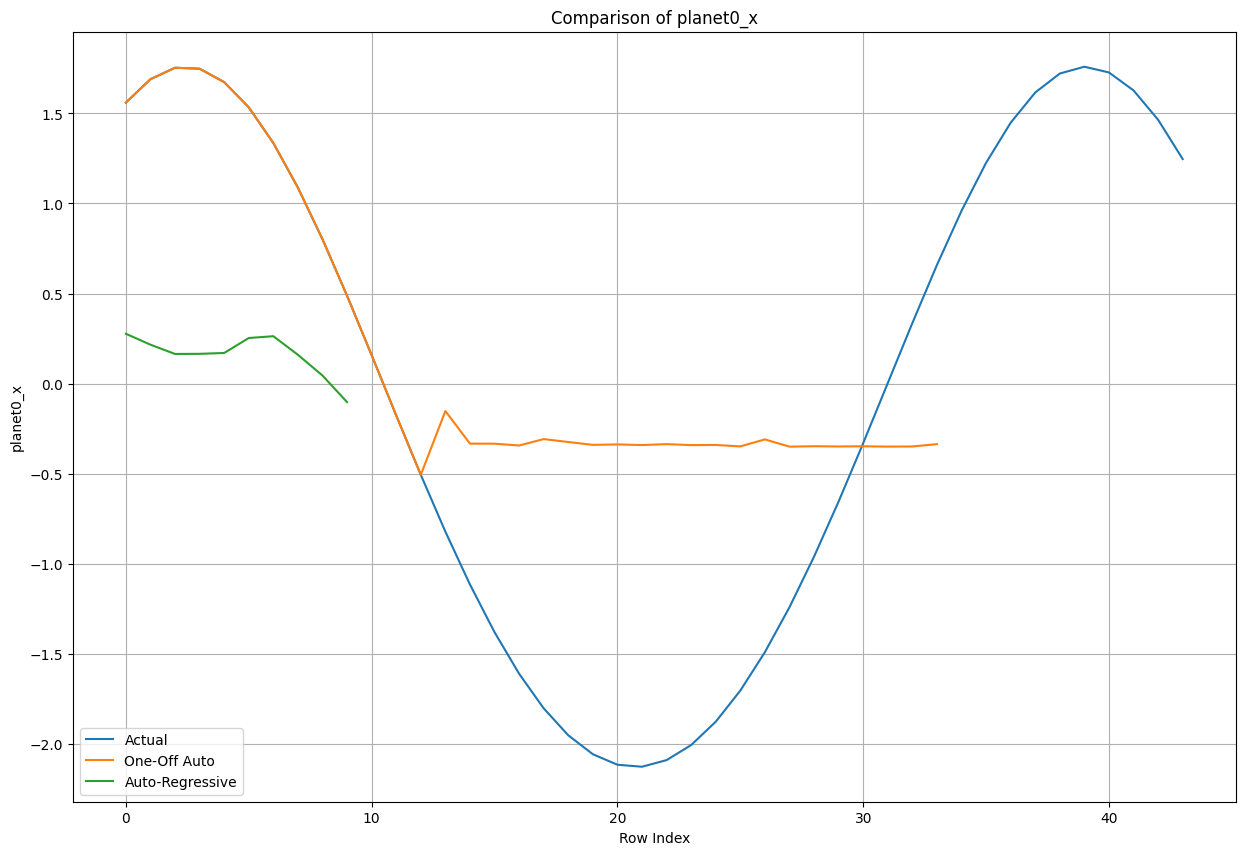

In [ ]:
plot_comparison(actual_df, auto_df, res_df, "planet0_x")

In [43]:
test_inputs.numeric_inputs.shape

(1, 27, 34)